In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from fit import *
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Simulate RL_nv with different $\sigma$, $v$

In [ ]:
def bayes_noise(obs, noise_n=0, noise_e=0, seed=0):
    rng = np.random.RandomState(seed=seed)
    expectation = 0
    for o in range(len(obs)):
        weight = 1/(o+3)
        dW = rng.uniform((1-noise_n)*weight, (1+noise_n)*weight)
        weight = dW
        weight = np.clip(weight, 0, 1)
        error = obs[o] - expectation
        expectation += weight * error
        dE = rng.uniform((1-noise_e)*expectation, (1+noise_e)*expectation)
        expectation = dE
        expectation = np.clip(expectation, -1, 1)
    weight_ideal = 1/(o+3)
    expectation_ideal = bayes_ideal(obs)
    return weight_ideal, weight, expectation_ideal, expectation

In [2]:
def run_RLn(sid, sigma):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    params = [mu, sigma]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("RL_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["RL_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['sigma'] = sigma
    return dynamics_data

In [3]:
sid = 18
sigmas = [0.025, 0.05, 0.10]
dfs = []
for sigma in sigmas:
    dfs.append(run_RLn(sid, sigma))
RLn_data = pd.concat(dfs, ignore_index=True)

# Simulate NEF_RL with different $neurons$

In [2]:
def run_NEFRL(sid, n_neurons, n_error, n_learning):
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    trials = human['trial'].unique() 
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    dfs = []
    for trial in trials:
        print(f"n_neurons {n_neurons}, n_error {n_error}, n_learning {n_learning}, sid {sid}, trial {trial}")
        env = Environment(dataset="carrabin", sid=sid, trial=trial, decay="stages", s=[mu,mu,mu,mu,mu])
        seed_net = sid + 1000*trial
        net = build_network_RL(env, n_neurons=n_neurons, n_error=n_error, n_learning=n_learning, seed_net=seed_net, z=0, a=5e-5)
        sim = nengo.Simulator(net, seed=trial, progress_bar=False)
        with sim:
            sim.run(env.Tall, progress_bar=False)
        for stage in env.stages:
            tidx = int((stage*env.T)/env.dt)-2
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = sim.data[net.probe_value][tidx][0]
            df = pd.DataFrame([['NEF_RL', sid, trial, stage, qid, response]], columns=columns)
            dfs.append(df)
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['n_neurons'] = n_neurons
    dynamics_data['n_error'] = n_error
    dynamics_data['n_learning'] = n_learning
    return dynamics_data

In [4]:
def process_plot(human, NEFRL_data):
    human['n_neurons'] = 'human'
    human['n_error'] = 'human'
    human['n_learning'] = 'human'
    combined = pd.concat([human, NEFRL_data], ignore_index=True)
    combined['alpha'] = None
    combined['excursion'] = None
    for i, row in combined.iterrows():
        mt = row['type']
        trial = row['trial']
        stage = row['stage']
        qid = row['qid']
        n_neurons = row['n_neurons']
        n_error = row['n_error']
        n_learning = row['n_learning']
        response = row['response']
        avg_response = combined.query("type==@mt & n_neurons==@n_neurons & n_error==@n_error & n_learning==@n_learning & qid==@qid")['response'].mean()
        combined.at[i, 'excursion'] = response - avg_response
        if stage>1:
            stage_old = stage - 1
            response_old = combined.query("type==@mt & trial==@trial & n_neurons==@n_neurons & n_error==@n_error & n_learning==@n_learning & stage==@stage_old")['response'].to_numpy()[0]
            delta = response_old - response
            color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
            prediction_error = color - response_old
            alpha = np.abs(delta / prediction_error)
            combined.at[i, 'alpha'] = alpha
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex='col', sharey='col')
    # plot learning rates on left
    sns.kdeplot(combined, x='alpha', hue='n_learning', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
    sns.kdeplot(combined, x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
    # plot excursions on right
    sns.kdeplot(combined, x='excursion', hue='n_learning', ax=axes[0][1], palette=palette[:4], fill=True, common_norm=False)
    sns.kdeplot(combined, x='excursion', hue='n_error', ax=axes[1][1], palette=palette[:4], fill=True, common_norm=False)
    axes[0][0].set(title='Distribution of Behavioral Learning Rates')
    axes[0][1].set(title='Distribution of Excursions', xlabel="Excursion", ylabel=None, xlim=[-0.5,0.5])
    axes[1][0].set(xlabel="Learning Rate")
    axes[1][1].set(ylabel=None, xlabel='Excursion')
    plt.tight_layout()
    plt.show()

In [5]:
sid = 18

# n_neurons = [50, 200]
n_error = [50, 200]
# n_learning = [50, 200]
n = 200
# e = 100
l = 200
dfs = []
# for n in n_neurons:
for e in n_error:
    # for l in n_learning:
    dfs.append(run_NEFRL(sid, n, e, l))
NEFRL_data = pd.concat(dfs, ignore_index=True)
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")

n_neurons 200, n_error 50, n_learning 200, sid 18, trial 1
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 2
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 3
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 4
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 5
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 6
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 7
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 8
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 9
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 10
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 11
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 12
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 13
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 14
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 15
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 16
n_neurons 200, n_error 50, n_learning 200, sid 18

KeyboardInterrupt: 

In [ ]:
process_plot(human, NEFRL_data)

## Load and Plot

In [18]:
noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13two.pkl")
# noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13test.pkl")
human = pd.read_pickle("data/carrabin.pkl").query("sid==1")

In [19]:
def add_excursion_alpha(data):
    for i, row in data.iterrows():
        mt = row['type']
        trial = row['trial']
        stage = row['stage']
        qid = row['qid']
        n_learning = row['n_learning']
        n_error = row['n_error']
        response = row['response']
        avg_response = data.query("type==@mt & n_learning==@n_learning & n_error==@n_error & qid==@qid")['response'].mean()
        data.at[i, 'excursion'] = response - avg_response
        if stage>1:
            stage_old = stage - 1
            response_old = data.query("type==@mt & trial==@trial & n_error==@n_error & n_learning==@n_learning & stage==@stage_old")['response'].to_numpy()[0]
            delta = response_old - response
            color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
            prediction_error = color - response_old
            alpha = np.abs(delta / prediction_error)
            data.at[i, 'alpha'] = alpha
    return data

In [20]:
# human['n_learning'] = 'human'
# human['n_error'] = 'human'
# combined = pd.concat([human, noise_data])
# combined_add = add_excursion_alpha(combined)
combined_add = add_excursion_alpha(noise_data)

In [21]:
combined_add

,type,sid,trial,stage,qid,n_learning,n_error,response,excursion,alpha
0,NEF_RL,1,1,1,1,40,40,-0.023887,-0.111359,NaN
1,NEF_RL,1,1,2,10,40,40,-0.089241,-0.085655,0.066954
2,NEF_RL,1,1,3,100,40,40,-0.160070,-0.097256,0.077769
3,NEF_RL,1,1,4,1000,40,40,-0.225365,-0.102643,0.077738
4,NEF_RL,1,1,5,10000,40,40,-0.161584,-0.004581,0.082337
...,...,...,...,...,...,...,...,...,...,...
24995,NEF_RL,1,200,1,1,120,120,0.152568,0.039224,NaN
24996,NEF_RL,1,200,2,11,120,120,0.312497,0.100900,0.188722
24997,NEF_RL,1,200,3,111,120,120,0.472270,0.174981,0.232395
24998,NEF_RL,1,200,4,1111,120,120,0.569429,0.211449,0.184109


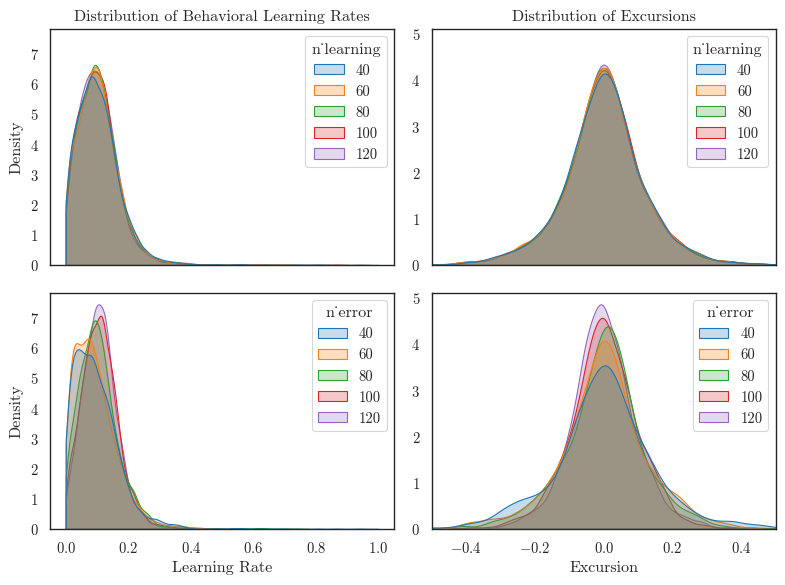

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex='col', sharey='col')
sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='alpha', hue='n_learning', ax=axes[0][0], clip=[0, 1], palette=palette[:5], fill=True, common_norm=False)
sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:5], fill=True, common_norm=False)
sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='excursion', hue='n_learning', ax=axes[0][1], palette=palette[:5], fill=True, common_norm=False)
sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='excursion', hue='n_error', ax=axes[1][1], palette=palette[:5], fill=True, common_norm=False)
axes[0][0].set(title='Distribution of Behavioral Learning Rates')
axes[0][1].set(title='Distribution of Excursions', xlabel="Excursion", ylabel=None, xlim=[-0.5,0.5])
axes[1][0].set(xlabel="Learning Rate")
axes[1][1].set(ylabel=None, xlabel='Excursion')
plt.tight_layout()
plt.show()

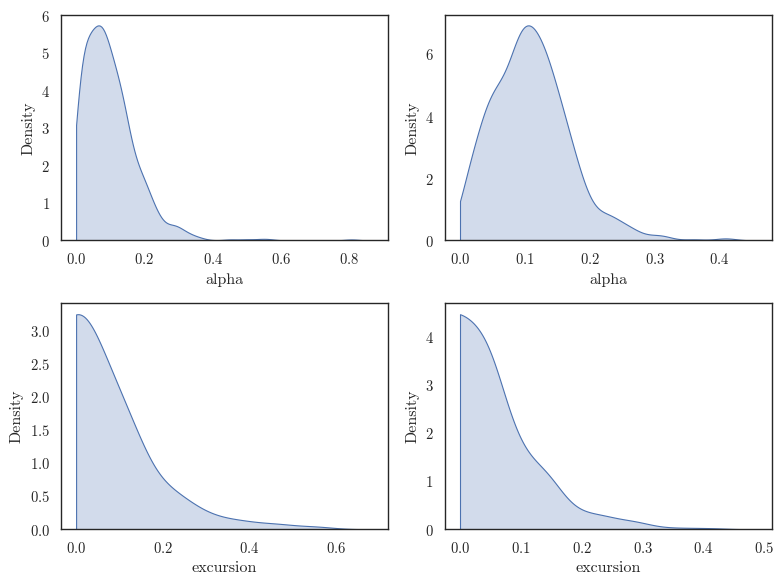

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
sns.kdeplot(combined_add.query("n_learning==40 & n_error==40"), x='alpha', ax=axes[0][0], clip=[0, 1], fill=True, common_norm=False)
sns.kdeplot(combined_add.query("n_learning==40 & n_error==120"), x='alpha', ax=axes[0][1], clip=[0, 1], fill=True, common_norm=False)
sns.kdeplot(combined_add.query("n_learning==40 & n_error==40"), x='excursion', ax=axes[1][0], clip=[0, 1], fill=True, common_norm=False)
sns.kdeplot(combined_add.query("n_learning==40 & n_error==120"), x='excursion', ax=axes[1][1], clip=[0, 1], fill=True, common_norm=False)
# axes[0][0].set(title='Distribution of Behavioral Learning Rates')
# axes[0][1].set(title='Distribution of Excursions', xlabel="Excursion", ylabel=None, xlim=[-0.5,0.5])
# axes[1][0].set(xlabel="Learning Rate")
# axes[1][1].set(ylabel=None, xlabel='Excursion')
plt.tight_layout()
plt.show()

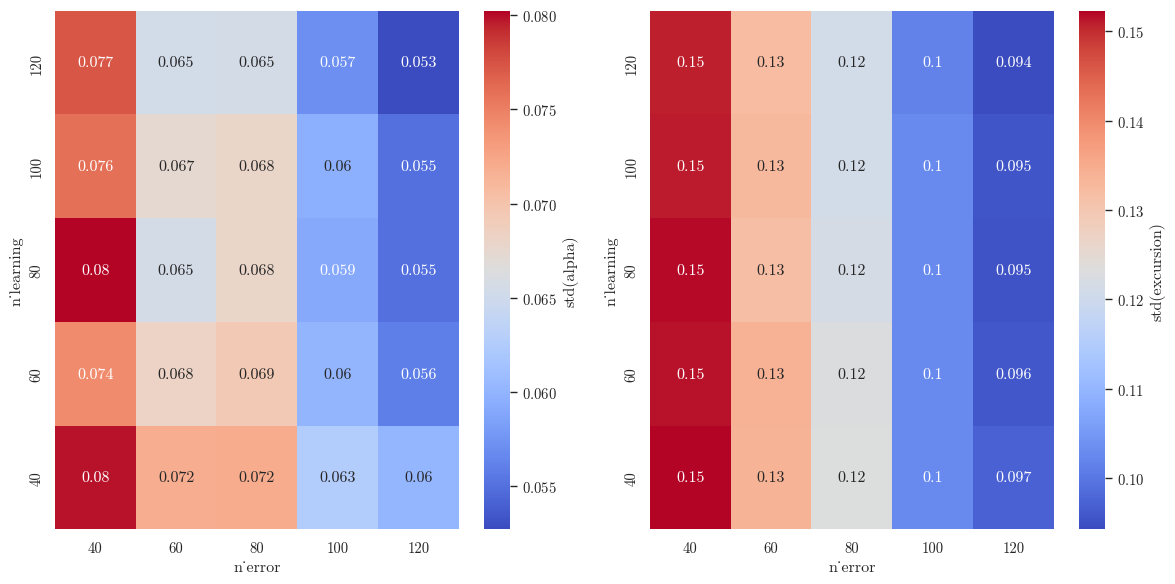

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
# error_number = noise_data.pivot_table(index='n_learning', columns='n_error', values='alpha', aggfunc=np.std)
# error_expectation = noise_data.pivot_table(index='n_learning', columns='n_error', values='excursion', aggfunc=np.std)
alpha_pivot = combined_add.pivot_table(index='n_learning', columns='n_error', values='alpha', aggfunc=np.std)
excursion_pivot = combined_add.pivot_table(index='n_learning', columns='n_error', values='excursion', aggfunc=np.std)
sns.heatmap(data=alpha_pivot, annot=True, cmap="coolwarm", cbar_kws={'label': 'std(alpha)'}, ax=axes[0])
sns.heatmap(data=excursion_pivot, annot=True, cmap="coolwarm", cbar_kws={'label': 'std(excursion)'}, ax=axes[1])
axes[0].invert_yaxis()
axes[1].invert_yaxis()
# axes[0].set(xlabel="Neurons in Learning Pops.", ylabel="Neurons in Error Pop", title="Standard Deviation of Behavioral Learning Rates")
# axes[1].set(xlabel="Neurons in Learning Pops.", ylabel="Neurons in Error Pop", title="Standard Deviation of Excursions")
plt.tight_layout()
fig.savefig("plots/noise_RL_vs_neurons.jpg", dpi=600)